The following jupyter notebook is assumed to be using the same kernel as the one where the `src` package was installed.

In [48]:
%reload_ext autoreload
%autoreload 2

import os
import io
import pickle
import sys
import time
import json
import datetime
import joblib

import boto3
import sagemaker
from sagemaker.model import Model
from sagemaker.serverless.serverless_inference_config import ServerlessInferenceConfig
from sagemaker.estimator import Estimator
from sagemaker.predictor import Predictor
from sagemaker.processing import Processor, ProcessingInput, ProcessingOutput
from sagemaker.tuner import ContinuousParameter, IntegerParameter, CategoricalParameter, HyperparameterTuner
from tqdm import tqdm

import numpy as np
import pandas as pd
from hydra import compose, initialize, core
from omegaconf import OmegaConf

import matplotlib.pyplot as plt
from src.train_entry import TSTrainer
from src.lambda_manager import LambdaManager
from src.rest_api_manager import RestApiManager

## Hydra

In [2]:
core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base='1.2', config_path='../src/config', job_name='forecast')
config = OmegaConf.to_container(compose(config_name='main'), resolve=True)

## S3

These are the S3 paths:

* The processing job downloads the raw data files from the `raw_data_path` from S3

* The processing job uploads the preprocessed data to the designated training and testing channels located in `train_val_test_path`, setting the stage for the training phase

* Subsequently, the training job accesses and downloads the preprocessed data from each specified channel within `train_val_test_path` onto the training image for utilization

In [3]:
s3 = boto3.client('s3')

raw_data_path = f's3://{config["s3_bucket"]}/{config["s3_key"]}/raw-data'

train_val_test_path = {
    'train': f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data/train',
    'test': f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data/test'
}
train_val_test_path, raw_data_path

({'train': 's3://yang-ml-sagemaker/forecast-project/input-data/train',
  'test': 's3://yang-ml-sagemaker/forecast-project/input-data/test'},
 's3://yang-ml-sagemaker/forecast-project/raw-data')

## SageMaker

These are used to manage the SageMaker session in this notebook:

* The sagemaker session manages any underlying interactions with the AWS Sagemaker APIs, and we specify a default bucket

* The sagemaker boto3 client is used for removing endpoint upon the completion of this project

* The ECR boto3 client is also used for removing images upon the completion of this project

* The lambda boto3 client is used for creating and removing lambda function upon the completion of this project

* The IAM boto3 client is passed to the lambda wrapper class for creating and and working with Lambda

* The api gateway client is used to create and remove api gateways upon the completion of the project

* The role is used to access AWS resources such as data stored in S3, which is the one we created earlier

In [ ]:
sagemaker_session = sagemaker.Session(default_bucket=config['s3_bucket'])
sm_boto3 = boto3.client('sagemaker')
ecr_boto3 = boto3.client('ecr')
lambda_boto3 = boto3.client('lambda')
iam_boto3 = boto3.resource('iam')
apigateway_boto3 = boto3.client('apigateway')
role = sagemaker.get_execution_role()

## Processing Job

| Section                         | Description                                                                                                                                                                                                                                                                                                                                                                                                                       |
|---------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Script Overview**             | The script `preprocess_entry.py` contains the logic for forecasting Covid-19 data using STL forecasting with naive methods for different components. It operates within AWS SageMaker as a processing job and includes a preprocess pipeline with a log transformation followed by STL forecasting for Covid-19 data.                                                                                                                             |
| **Key Libraries Used**          | - **pandas**: For data manipulation and analysis. <br> - **numpy**: For numerical operations. <br> - **sktime**: For advanced time series forecasting, particularly STL and naive forecasting methods. <br> - **argparse**: For command-line option and parsing hyperparameters passed to the preprocessing script at run-time. <br> - **hydra**: For managing configuration files. <br> - **logging**: For generating log messages. <br> - **warnings**: For handling warnings during script execution. |
| **Main Functionalities**        | 1. **Data Preparation**: Loads and preprocesses gas product data, including the boolean indicator for outlaying Covid-19 observations. <br> 2. **Model Configuration and Forecasting**: Sets up STL forecasting with naive methods for trend, seasonality, and residuals, and forecasts the Covid-19 data. <br> 3. **Data Splitting**: Divides the data into training and testing sets based on a specified forecast horizon. <br> 4. **Data Saving**: Saves processed data to disk, with an option to skip saving in test mode. |
| **STL Forecasting with Naive Methods** | Employs STL forecasting, decomposing the time series into trend, seasonal, and residual components, each forecasted using the naive method with `strategy = mean`. This approach is encapsulated in a `forecast` function that manages the forecasting process.                                                                                                                                                                                             |
| **Configuration Management**    | Utilizes Hydra for managing configuration parameters, allowing for easy adjustment of settings separated from the code. Configuration parameters are accessed from a dictionary object.                                                                                                                                                                                                                                                |
| **Testing with Local Mode**     | Includes a `--test_mode` argument for local testing, which reduces data size and skips saving results to disk. This feature is useful for testing the script in a local environment before deploying it to AWS SageMaker.                                                                                                                                                                                                            |
| **Logging and Warning Handling** | Implements logging for tracking the script's execution process and uses the `warnings` module to manage warning messages during execution, especially in the forecasting function.                                                                                                                                                                                        |

### Docker Image for Preprocessing

The `build_and_push.sh` script takes three arguments:

* `image_tag`: tag of the docker image

* `mode`: one of 'preprocess', 'train', 'serve'

* `ecr_repo`: name of the ECR private repository

This script automates the the task of building docker images for a given task--- preprocess, train, or serve--- and pushes it to the ECR repository we created earlier.

In [ ]:
!cd {config['docker_dir_path']} && bash ./build_and_push.sh preprocess-latest preprocess {config['ecr_repository']}

Construct the processing job image uri:

In [5]:
images = !aws ecr list-images --repository-name {config['ecr_repository']}
images_str = '\n'.join(images)
images_str = json.loads(images_str)

for ecr_meta_data_dict in images_str['imageIds']:
    if ecr_meta_data_dict['imageTag'].startswith('preprocess'):
        preprocess_image_tag = ecr_meta_data_dict['imageTag']

preprocess_image_uri = f'{sagemaker_session.account_id()}.dkr.ecr.{sagemaker_session.boto_region_name}.amazonaws.com/{config["ecr_repository"]}:{preprocess_image_tag}'

### Test Processing Job Locally

In [8]:
# Clear tmp directory in case we run out of space
!sudo rm -rf /tmp/tmp*

In [ ]:
test_processor = Processor(
    image_uri=preprocess_image_uri,
    role=role,
    instance_type='local',
    instance_count=config['preprocess_instance_count'],
    base_job_name=config['preprocess_base_job_name'],
    entrypoint=['python3', 'preprocess_entry.py']
)

test_processor.run(
    # The data sets are loaded from the source S3 path to the destination path in the processing container
    inputs=[ProcessingInput(
        source=raw_data_path,
        destination=config['preprocess_input']
    )],
    outputs=[
        ProcessingOutput(
            # The processing script writes train and test splits to these locations in the container
            source=os.path.join(config['preprocess_output'], key),
            # Processing job will upload the preprocessed data to this S3 uri
            destination=train_val_test_path[key]
        ) for key in train_val_test_path
    ],
    # Run in test mode to not upload the preprocessed data to S3
    arguments=['--test_mode']
)

### Run Processing Job in the Cloud

In [ ]:
processor = Processor(
    image_uri=preprocess_image_uri,
    role=role,
    instance_type=config['preprocess_instance_type'],
    instance_count=config['preprocess_instance_count'],
    base_job_name=config['preprocess_base_job_name'],
    sagemaker_session=sagemaker_session,
    entrypoint=['python3', 'preprocess_entry.py']
)

processor.run(
    # The data sets are loaded from the source S3 path to the destination path in the processing container
    inputs=[ProcessingInput(
        source=raw_data_path,
        destination=config['preprocess_input']
    )],
    outputs=[
        ProcessingOutput(
            # The processing script writes train and test splits to these locations in the container
            source=os.path.join(config['preprocess_output'], key),
            # Processing job will upload the preprocessed data to this S3 uri
            destination=train_val_test_path[key]
        ) for key in train_val_test_path
    ]
)

### Visualize Counterfactual Data

We can download the processed data from S3 and visualize the counterfactual data versus the original time series:

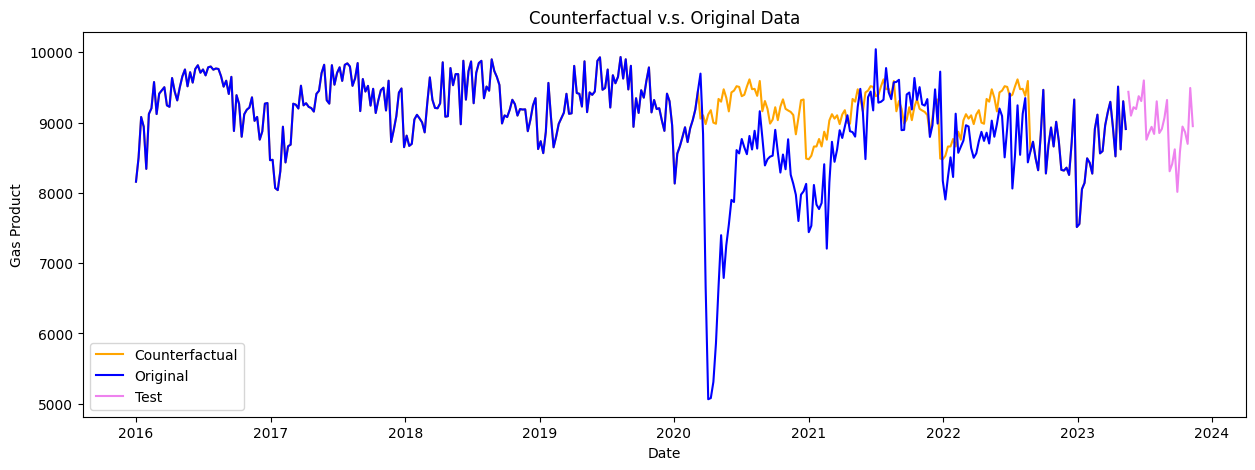

In [31]:
train = pd.read_csv(os.path.join(train_val_test_path['train'], 'train.csv'), index_col=0)
train.index = pd.to_datetime(train.index)
train.index.freq = config['freq']
test = pd.read_csv(os.path.join(train_val_test_path['test'], 'test.csv'), index_col=0)
test.index = pd.to_datetime(test.index)
test.index.freq = config['freq']

fig, ax = plt.subplots(figsize=(15, 5))
# Plot original data
ax.plot(train.loc ['2016':'2023']['gas_product_forecast'], label='Counterfactual', color='orange')
ax.plot(train.loc['2016':'2023']['gas_product'], label='Original', color='blue')
ax.plot(test['gas_product'], label='Test', color='violet')
ax.set_xlabel('Date')
ax.set_ylabel('Gas Product')
ax.set_title('Counterfactual v.s. Original Data')
plt.legend(loc='best')
plt.show()

As mentioned in the exploratory data analysis, the counterfactual (yellow) data could be interpreted as the gasoline production levels that might have been attained if the pandemic had not happened; they could serve as the benchmark that producers should aim to return to.

## Training Job

| Section                             | Description                                                                                                                                                                                                                                                                                                                                                                                                                      |
|-------------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Script Overview**                 | The `train_entry.py` script is designed for building, training, and evaluating a time series forecasting model using a harmonic regression model with ARIMA error. This script is tailored for execution within AWS SageMaker as a training job, with capabilities for local testing, spot training, and automatic model tuning.                                                                                                                                               |
| **Key Libraries Used**              | - **pandas**: For data manipulation and analysis. <br> - **numpy**: For numerical operations. <br> - **sktime**: For time series forecasting and model selection. <br> - **joblib**: For model serialization and deserialization. <br> - **matplotlib**: For plotting and visualizing data. <br> - **scipy** and **statsmodels**: For statistical tests and diagnostics.                                                                 |
| **Main Functionalities**            | 1. **Data Loading**: Reads training and test data from CSV files. <br> 2. **Model Building**: Constructs a harmonic regression model with optional detrending and deseasonalization, and Fourier feature transformation. <br> 3. **Training & Cross-Validation**: Implements time series cross-validation with sliding window splits. <br> 4. **Model Evaluation**: Calculates mean squared error for model evaluation. <br> 5. **Model Refitting & Persistence**: Refits the model on the entire dataset and serializes it for future use. |
| **Model Building and Training**     | Constructs a harmonic regression model using ARIMA and Fourier features, with optional preprocessing steps such as detrending and deseasonalization based on hyperparameters. Training involves fitting this model on time series data, with support for automatic model tuning in AWS SageMaker.                                                                                                                                         |
| **Cross-Validation and Evaluation** | Implements a sliding window cross-validation strategy for time series data. Evaluates the model's performance using Mean Squared Error (MSE) and logs the results. Supports local mode testing and managed spot training for cost-efficient resource utilization.                                                                                                                                                                  |
| **Model Persistence**               | After training, the script serializes the model and Fourier transformer using joblib, and saves them along with the training data. Supports saving of intermediate models and diagnostics in AWS SageMaker's managed environment.                                                                                                                                                                                                |
| **Visualization and Diagnostics**   | Includes functions for plotting forecasted data, cross-validation strategy, and performing diagnostic tests (Shapiro-Wilk and Ljung-Box) on the model residuals. Useful in assessing the model's assumptions and performance.                                                                                                                                                                                                                                  |
| **Configuration and Logging**       | Utilizes Hydra for configuration management and standard Python logging for logging messages. Handles warnings during script execution. Incorporates configuration options for local testing, spot training, and automatic model tuning.                                                                                                                                 |

### Cross-Validation

The `train_entry.py` script employs a [sliding window cross-validation](https://otexts.com/fpp3/tscv.html) strategy for evaluating the time series forecasting model. This approach is particularly well-suited for time series data, ensuring that the temporal structure of the data is respected during the training and validation process. Here's an overview of the cross-validation method implemented:

- **Sliding Window Cross-Validation**: This method involves moving a fixed-size window over the time series data to create multiple training and validation sets. Each set consists of a continuous sequence of observations, maintaining the time order.
- **Implementation Details**:
    - **Window Sizes**: The window size (`w`), step size (`s`), and forecast horizon (`h`) are key parameters. The window size determines the length of each training set, the step size controls the movement of the window, and the forecast horizon sets the length of the validation set.
    - **Temporal Consistency**: By using this method, the script ensures that each validation set only includes future data points relative to its corresponding training set, preserving the temporal order crucial for accurate time series forecasting.
    - **Number of Splits**: Given `n` (the total length of the time series), `w` (window size), `h` (forecast horizon), and `s` (step size), the number of train-validation splits is calculated as follows:
    $$
    \left[ \frac{n - w - h}{s} \right] + 1
    $$
    Where $[\cdot]$ is the floor division operator. This formula ensures that each split is properly aligned within the time series while respecting the constraints set by the window size, step size, and forecast horizon.
- **Advantages**:
    - **Realistic Evaluation**: Mimics a real-world scenario where a model is trained on past data and used to predict future outcomes.
    - **Robustness**: Provides a thorough assessment of the model's performance over different time periods, making the evaluation more robust against anomalies or non-representative data segments.
- **Integration with Model Evaluation**: The script calculates the Mean Squared Error (MSE) for each split, aggregating these to assess the overall performance of the model. This metric provides a clear quantitative measure of the model's forecasting accuracy.

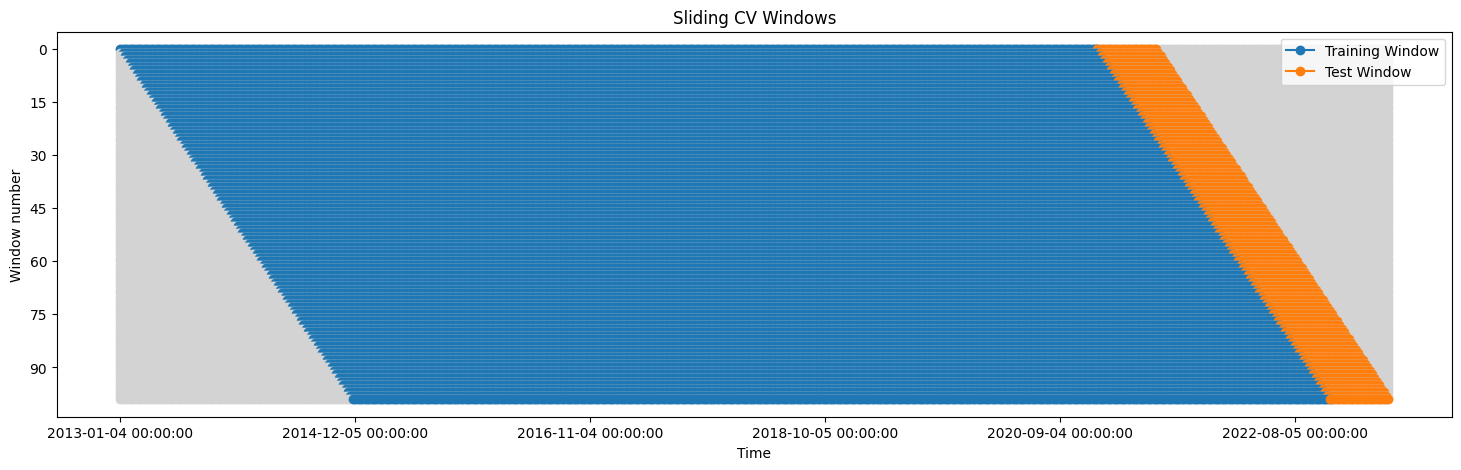

In [50]:
TSTrainer.plot_sliding_cv_windows(
    w=config['cv_window_size'],
    s=config['step_length'],
    h=config['forecast_horizon'],
    start_date=str(train.index.min().date()),
    end_date=str(train.index.max().date()),
    freq=train.index.freqstr,
    title='Sliding CV Windows',
    figsize=(18, 5)
)

### Docker Image for Training

In [ ]:
!cd {config['docker_dir_path']} && bash ./build_and_push.sh train-latest train {config['ecr_repository']}

Construct the training job image uri:

In [6]:
images = !aws ecr list-images --repository-name {config['ecr_repository']}
images_str = '\n'.join(images)
images_str = json.loads(images_str)

for ecr_meta_data_dict in images_str['imageIds']:
    if ecr_meta_data_dict['imageTag'].startswith('train'):
        train_image_tag = ecr_meta_data_dict['imageTag']

train_image_uri = f'{sagemaker_session.account_id()}.dkr.ecr.{sagemaker_session.boto_region_name}.amazonaws.com/{config["ecr_repository"]}:{train_image_tag}'

### Automatic Model Tuning

In the context of our training with Amazon SageMaker, [Automatic Model Tuning (AMT)](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html), also known as hyperparameter tuning, plays a pivotal role. AMT optimizes the process of model training by systematically iterating over various hyperparameter combinations to discover the most effective model configuration. This approach is particularly significant in our project's context, where we aim to forecast gasoline product data with precision.

#### Integrating AMT with Custom Training Script

Our custom training script, embodied in the `TSTrainer` class, is designed to handle various hyperparameters like `preprocess_detrend`, `preprocess_deseasonalize`, and `preprocess_fourier_k`.

- `preprocess_detrend`: This hyperparameter controls a tunable (on/off) step to the remove trends from the time series data, making the series more stationary and suitable for statistical modeling.
- `preprocess_deseasonalize`: This is another tunable (on/off) preprocessing step that seeks to identify and remove the seasonality from the time series data, which is another requirement for stationarity.
- `preprocess_fourier_k`: This hyperparameter determines the number of Fourier terms used for transforming the time series, aiding in capturing and leveraging cyclical patterns within the data. This is the part that makes our model a harmonic regression model, making it suitable for modeling [long seasonal periods](https://robjhyndman.com/hyndsight/longseasonality/) like our weekly gasoline product data.

Incorporating AMT with our training script involves the following steps:

1. **Specifying Hyperparameter Ranges**: For hyperparameters like `preprocess_detrend` , `preprocess_deseasonalize`, and `preprocess_fourier_k`, we define a range of values that AMT will explore. The SageMaker python SDK supports:
    - **Continuous Parameters**: For hyperparameters that take on a continuous range of values.
    - **Integer Parameters**: For hyperparameters that take on a discrete range of integer values.
    - **Categorical Parameters**: For hyperparameters that take on a discrete range of categorical values.
    
    In this project, we use the `IntegerParameter` type for `preprocess_fourier_k` and `CategoricalParameter` type for `preprocess_detrend` and `preprocess_deseasonalize`, which are either `True` (include this preprocessing step) or `False` (do not include this preprocessing step).
2. **Setting Up the Training Job**: We set up the SageMaker training job by specifying our custom training docker image uri and the hyperparameter ranges for tuning.
3. **Optimization Objective**: Choosing the right metric, such as Mean Squared Error (MSE), which our script calculates during the cross-validation process, guides AMT towards optimizing model performance across each cross-validation split.

We use Bayesian optimization for tuning our forecasting model, which sets up hyperparameter tuning as a regression problem:

* **Regression-Based Exploration**: The optimization process begins with educated guesses about potential hyperparameter values and iteratively refines these guesses based on the observed performance.
* **Balancing Exploration and Exploitation**: AMT alternates between exploring new hyperparameter regions and exploiting known combinations that have yielded promising results, effectively balancing the need to discover new solutions and optimize known configurations.

Another reason for using Bayesian optimization is as follows:

- **Total Combinations:** 40
  - **Integer Hyperparameter (1-10):** 10 options (`preprocess_fourier_k`)
  - **Two Boolean Hyperparameters:** 2 options each (`preprocess_detrend` & `preprocess_deseasonalize`)

With brute force grid search:

- **Approach:** Tests every possible combination.
- **Combinations:** 40 in total.
- **Pros:** Simple, exhaustive.
- **Cons:** Time-consuming and computationally expensive.

If we switch to Bayesian optimization

- **Approach:** Uses a probabilistic model to guide the search.
- **Pros:** 
  - **Efficient:** Requires fewer trials (i.e., we use only 20 trials in this project)
  - **Smart Search:** Prioritizes more promising hyperparameters based on previous results.
- **Cons:** 
  - More complex implementation.
  - May miss some less obvious solutions.

Bayesian optimization is generally more efficient than brute force grid search, especically when the number of hyperparameter combinations becomes large, as it strategically explores the parameter space and may converge faster to *optimal* solutions. More details on Sagemaker AMT and Bayesian optimization can be found in the [official documentations](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning-how-it-works.html).

### Test Training Job Locally

In [21]:
# Clear tmp directory in case we run out of space
!sudo rm -rf /tmp/tmp*

In [ ]:
# Use fixed hyperparameters for testing
test_hyperparameters = {
    'test_mode': 1,
    'use_counterfactual_data': 1,
    'preprocess_detrend': 1,
    'preprocess_deseasonalize': 1,
    'preprocess_fourier_k': 2
}

test_estimator = Estimator(
    image_uri=train_image_uri,
    role=role,
    instance_count=config['train_instance_count'],
    instance_type='local',
    volume_size=config['volume_size'],
    output_path=config['output_path'],
    base_job_name=config['train_base_job_name'],
    hyperparameters=test_hyperparameters,
    code_location=config['code_location']
)

test_estimator.fit(train_val_test_path)

### Hyperparameter Tuning 

Define the hyperparameter search space:

In [54]:
search_space = {
    'use_counterfactual_data': CategoricalParameter([1, 0]),
    'preprocess_detrend': CategoricalParameter([1, 0]),
    'preprocess_deseasonalize': CategoricalParameter([1, 0]),
    'preprocess_fourier_k': IntegerParameter(min_value=1, max_value=config['max_k'])
}

Define metric to optimize:

In [59]:
metric_definitions = [
    {
        'Name': config['objective_metric_name'],
        # Regex for matching the logs outputted by the training script
        'Regex': 'Mean MSE across all splits: ([0-9\\.]+)',
    }
]

Define estimator with spot training:

In [ ]:
estimator = Estimator(
    image_uri=train_image_uri,
    role=role,
    instance_count=config['train_instance_count'],
    instance_type=config['train_instance_type'],
    volume_size=config['volume_size'],
    max_run=config['max_run'],
    output_path=config['output_path'],
    base_job_name=config['train_base_job_name'],
    hyperparameters={
        'test_mode': 0
    },
    code_location=config['code_location'],
    use_spot_instances=config['use_spot_instances'],
    max_wait=config['max_wait'],
    checkpoint_s3_uri=config['checkpoint_s3_uri'],
    max_retry_attempts=config['max_retry_attempts']
)

Define hyerparameter tuner:

In [61]:
tuner = HyperparameterTuner(
    estimator=estimator,
    objective_metric_name=config['objective_metric_name'],
    hyperparameter_ranges=search_space,
    metric_definitions=metric_definitions,
    strategy=config['strategy'],
    objective_type=config['objective_type'],
    max_jobs=config['max_jobs'],
    max_parallel_jobs=config['max_parallel_jobs'],
    base_tuning_job_name=config['base_tuning_job_name']
)

In [62]:
tuner.fit(train_val_test_path)

INFO:sagemaker:Creating hyperparameter tuning job with name: tuning-job-231118-0627


............................................................................................................................................!


### Visualize Hyperparameter Optimization

In [70]:
hpo_analytics = sagemaker.HyperparameterTuningJobAnalytics(tuner.latest_tuning_job.name)

hpo_results = hpo_analytics.dataframe()

hpo_results.sort_values('FinalObjectiveValue', ascending=True)

,preprocess_deseasonalize,preprocess_detrend,preprocess_fourier_k,use_counterfactual_data,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
1,1.0,0.0,2.0,1.0,tuning-job-231118-0627-019-07dc2def,Completed,71444.132812,2023-11-18 06:34:54+00:00,2023-11-18 06:37:41+00:00,167.0
3,1.0,0.0,3.0,1.0,tuning-job-231118-0627-017-f4e974c3,Completed,71473.921875,2023-11-18 06:34:25+00:00,2023-11-18 06:37:32+00:00,187.0
16,1.0,0.0,5.0,1.0,tuning-job-231118-0627-004-8927369d,Completed,71600.453125,2023-11-18 06:28:32+00:00,2023-11-18 06:32:04+00:00,212.0
5,1.0,0.0,1.0,1.0,tuning-job-231118-0627-015-c0e596c2,Completed,71957.757812,2023-11-18 06:34:18+00:00,2023-11-18 06:36:50+00:00,152.0
8,1.0,1.0,1.0,1.0,tuning-job-231118-0627-012-ba06d228,Completed,72047.687500,2023-11-18 06:33:18+00:00,2023-11-18 06:35:35+00:00,137.0
4,1.0,0.0,9.0,1.0,tuning-job-231118-0627-016-bca216b8,Completed,72320.273438,2023-11-18 06:34:18+00:00,2023-11-18 06:38:55+00:00,277.0
2,1.0,0.0,8.0,1.0,tuning-job-231118-0627-018-fd6afcf8,Completed,72833.226562,2023-11-18 06:35:04+00:00,2023-11-18 06:39:06+00:00,242.0
18,1.0,1.0,8.0,1.0,tuning-job-231118-0627-002-9c774727,Completed,72932.828125,2023-11-18 06:28:39+00:00,2023-11-18 06:32:52+00:00,253.0
17,1.0,0.0,10.0,1.0,tuning-job-231118-0627-003-a2ef8f74,Completed,73276.046875,2023-11-18 06:28:38+00:00,2023-11-18 06:33:16+00:00,278.0
6,0.0,0.0,10.0,1.0,tuning-job-231118-0627-014-43cee29b,Completed,83250.273438,2023-11-18 06:34:03+00:00,2023-11-18 06:38:31+00:00,268.0


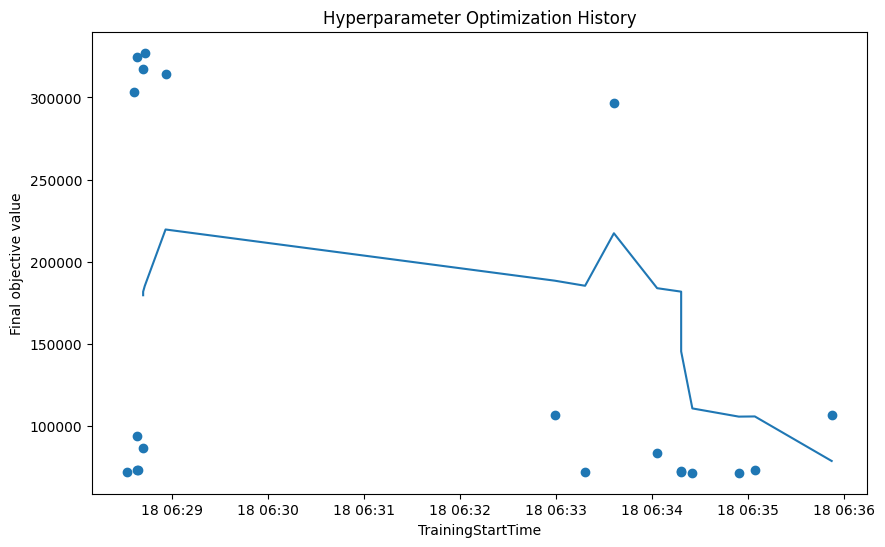

In [76]:
plt.figure(figsize=(10, 6))
# Sort by TrainingStartTime
hpo_results.sort_values('TrainingStartTime', inplace=True)
plt.scatter(hpo_results['TrainingStartTime'], hpo_results['FinalObjectiveValue'])
plt.plot(hpo_results['TrainingStartTime'], hpo_results['FinalObjectiveValue'].rolling(7).mean())
plt.xlabel('TrainingStartTime')
plt.ylabel('Final objective value')
plt.title('Hyperparameter Optimization History')
plt.show();

## Forecasts

Once the training has completed, the model artifacts will be uploaded to the specified s3 bucket; in our custom training script, the artifacts that were uploaded are as follows:

* Two modeling pipeline objects containing preprocessing steps and a final estimator (harmonic regression model)

    - The first was trained on the training set
    - The second was trained on the entire data set (train + test)

* Two fitted fourier feature transformers that can be used to generate fourier features (i.e., covariates) at prediction time

* The training set and the combined data set (train + test) 

In order to visualize the out-of-sample forecasts for the next 26 weeks (or ~ 6 months), we need to obtain the name and s3 path of the model artifacts with the best cross-validation MSE score:

In [7]:
best_model_name = sm_boto3.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.name
)['BestTrainingJob']['TrainingJobName']

# Obtain s3 path to model artifacts
best_model_s3_path = sm_boto3.describe_training_job(
    TrainingJobName=best_model_name
)['ModelArtifacts']['S3ModelArtifacts']

print(f'Best model artifacts persisted at {best_model_s3_path}')

Best model artifacts persisted at s3://yang-ml-sagemaker/forecast-project/models/tuning-job-231118-0627-019-07dc2def/output/model.tar.gz


Download the compressed archive file to local directory and uncompress:

In [ ]:
!aws s3 cp {best_model_s3_path} /tmp/model_artifacts.tar.gz
# The options -x = extract files from the archive, -z = uncompress the archive with gzip, -f = use archive file, and -C = change directory to the specified directory
!tar -xzf /tmp/model_artifacts.tar.gz -C /tmp

There are two models:

1. The first model was trained on the entire training set
2. The second (full) model was trained on the entire data set (train + test)

In [90]:
model_full = joblib.load('/tmp/model_full_target_pipeline.joblib')
fourier_transformer_full = joblib.load('/tmp/model_full_fourier_transformer.joblib')

model_train = joblib.load('/tmp/model_train_target_pipeline.joblib')
fourier_transformer_train = joblib.load('/tmp/model_train_fourier_transformer.joblib')

Let us forecast the test period and visualize the forecasts. First, we need to create the following data sets (note that we are using the counterfactual data based on the hyperparameter optimization results above):

In [97]:
y_train = train['gas_product_forecast'].copy()
y_train.index = pd.PeriodIndex(y_train.index, freq=config['freq'])

y_test = test['gas_product'].copy()
y_test.index = pd.PeriodIndex(y_test.index, freq=config['freq'])

y_full = pd.concat([y_train, y_test], axis=0)

The `TSTrainer` class in the training entrypoint contains a static method that allows us to plot the forecast results. Forecast plot for test period:

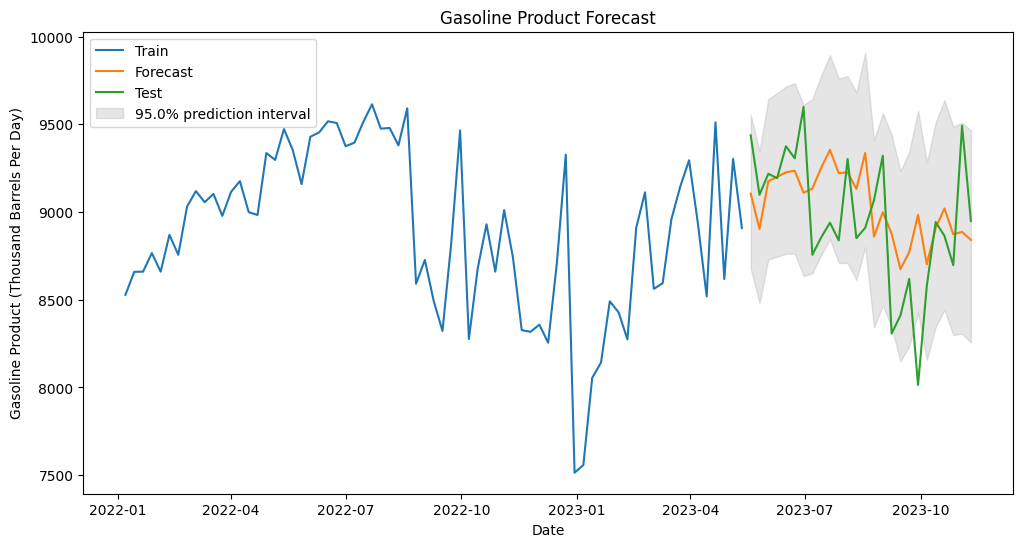

In [108]:
TSTrainer.plot_forecast(
    target_pipeline=model_train,
    fourier_transformer=fourier_transformer_train,
    y_train=y_train,
    y_test=y_test,
    conf=config['conf'],
    forecast_horizon=config['forecast_horizon'],
    start_date='2022-01-01'
)

Forecast plot for out-of-sample next 26 weeks:

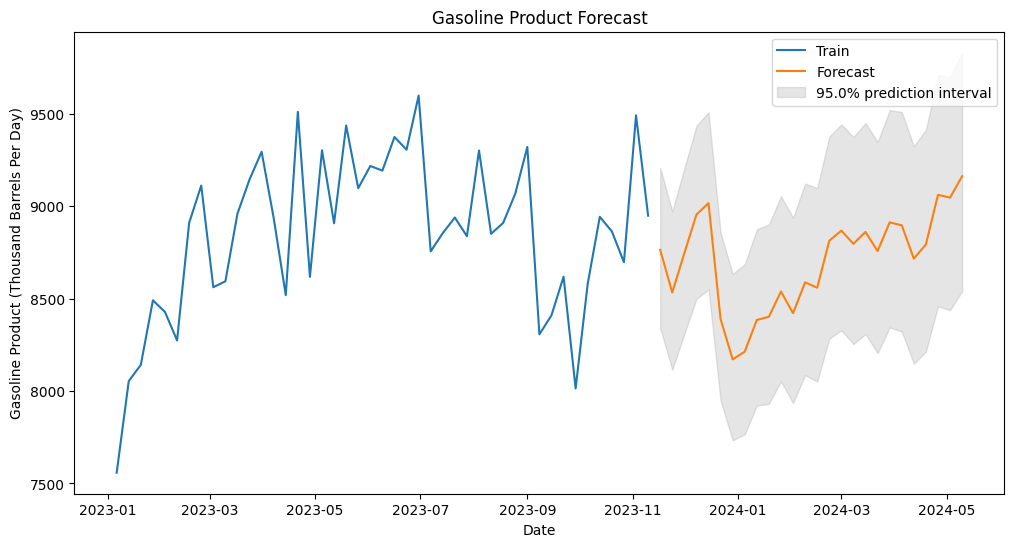

In [109]:
TSTrainer.plot_forecast(
    target_pipeline=model_full,
    fourier_transformer=fourier_transformer_full,
    y_train=y_full,
    y_test=None,
    conf=config['conf'],
    forecast_horizon=config['forecast_horizon'],
    start_date='2023-01-01'
)

## Model Diagnostics

In time series forecasting, conducting diagnostics tests is a vital step to ensure the validity and reliability of the model. These tests help us understand the behavior of the residuals (the differences between the observed and predicted values), which in turn gives insights into the model's accuracy and areas for improvement. The diagnostics method in our script performs two key statistical tests: the Shapiro-Wilk test and the Ljung-Box test.

### Shapiro-Wilk Test for Normality

**Purpose**: This test checks whether the residuals of the model follow a normal distribution. In many statistical models (which is our case), the assumption of normality in residuals is crucial for the validity of various statistical inferences.

### Ljung-Box Test for Autocorrelation

**Purpose**: This test checks for autocorrelation in the residuals at different lag intervals. Autocorrelation implies that the residuals are correlated with each other at different time lags, which can indicate model inadequacies or potential information that the model is not capturing.


Similar to the forecast visualization method, there is also a `diagnostics` static method in the `TSTrainer` class that can be used to conduct these statistical tests:

In [110]:
TSTrainer.diagnostics(
    target_pipeline=model_full,
    fourier_transformer=fourier_transformer_full,
    fh=config['forecast_horizon'],
    y_full=y_full
)

,Test,Null Hypothesis,P-Value,Reject at 1%,Reject at 5%,Reject at 10%
0,Shapiro-Wilk,Normality,4.127948e-10,True,True,True
1,Ljung-Box,No Autocorrelation,9.478134e-01,False,False,False


As can be seen, we fail to reject the null hypothesis of independent error, but we reject the null hypothesis of normality. 

At this juncture, it's crucial to consider the specific business context and requirements when deciding our next steps. If the project timeline and objectives prioritize rapid deployment over precision, and the current level of forecast accuracy aligns with business needs, we may proceed to deployment. However, if the business context demands a higher degree of inferential accuracy, it would be prudent for us to revisit and refine our models to ensure they adhere more closely to the underlying model assumptions. This decision is a delicate balance between technical perfection and practical business needs, and should be made in close consultation with stakeholders to align with the overarching goals and constraints of the project.

## Model Deployment with Lambda & API Gateway

### Deploy Best Model as Serverless Endpoint

Build and push the serving docker image to ECR:

In [ ]:
!cd {config['docker_dir_path']} && bash ./build_and_push.sh serve-latest serve {config['ecr_repository']}

Construct serving image uri:

In [7]:
images = !aws ecr list-images --repository-name {config['ecr_repository']}
images_str = '\n'.join(images)
images_str = json.loads(images_str)

for ecr_meta_data_dict in images_str['imageIds']:
    if ecr_meta_data_dict['imageTag'].startswith('serve'):
        serve_image_tag = ecr_meta_data_dict['imageTag']

serve_image_uri = f'{sagemaker_session.account_id()}.dkr.ecr.{sagemaker_session.boto_region_name}.amazonaws.com/{config["ecr_repository"]}:{serve_image_tag}'

Next, we create a sagemaker model instance, and use it to deploy the best model as a serverless endpoint. The key parameters are:

* Serving docker image

* S3 path of the best model artifacts

More details on the API [here](https://sagemaker.readthedocs.io/en/stable/api/inference/model.html).

In [8]:
best_model = Model(
    image_uri=serve_image_uri,
    model_data=best_model_s3_path,
    role=role,
    name=config['serve_model_name'],
    code_location=config['code_location'],
    sagemaker_session=sagemaker_session
)

Instantiate the `ServerlessInferenceConfig` class, which 

In [9]:
serverless_inference_config = ServerlessInferenceConfig(
    memory_size_in_mb=config['serve_memory_size_in_mb'],
    max_concurrency=config['serve_max_concurrency']
)

In [10]:
best_model.deploy(
    initial_instance_count=config['serve_initial_instance_count'],
    instance_type=config['serve_instance_type'],
    endpoint_name=config['serve_endpoint_name'],
    serverless_inference_config=serverless_inference_config,
    volume_size=config['serve_volume_size'],
    wait=True # Wait until the deployment finishes
)

----------!

### Lambda Function

We will use the `LambdaManager` (see `?LambdaManager` for details) class from the `src.lambda_manager` module, which contains methods to create, deploy, update, and delete lambda functions.

1. Set up the execution role:

In [11]:
lambda_manager = LambdaManager(
    lambda_client=lambda_boto3,
    iam_resource=iam_boto3
)

# Use the execution role we created for the lambda function
lambda_execution_role, exist = lambda_manager.create_iam_role_for_lambda(
    iam_role_name=config['lambda_execution_role_name']
)

2023-11-21 08:32:59,203 INFO src.lambda_manager: Found IAM role forecast-lambda-execution-role


2. Create deployment package for lambda function. This is the source code containing the `lambda_handler` function in the `src.lambda_function.py` module. This method creates a `bytes` object in memory, which we can deploy later:

In [12]:
deployment_package = lambda_manager.create_deployment_package(
    source_file=os.path.join(config['src_dir_path'], config['lambda_source_file']),
    destination_file=config['lambda_source_file']
)

type(deployment_package)

bytes

3. Create the lambda function:

    - Specify the function name, handler name, function description, python runtime, and IAM role (`forecast-lambda-execution-role`)

    - Pass the bytes representation of the source code and any environment variables (i.e., name of the SageMaker serverless endpoint with the `forecast-` prefix)

    - We also set the `time_out` parameter to 30 seconds, which is the maximum amount of time the function can run before terminating

In [13]:
lambda_function_arn = lambda_manager.create_function(
    function_name=config['lambda_function_name'],
    function_description=config['lambda_function_description'],
    time_out=config['lambda_time_out'],
    python_runtime=config['lambda_python_runtime'],
    iam_role=lambda_execution_role,
    handler_name=config['lambda_handler_name'],
    deployment_package=deployment_package,
    publish=config['lambda_publish'],
    # The configuration structures the env_vars as a list of dicts, but the SDK expects a single dict of key-value pairs
    env_vars={env_key: env_value for dict_obj in config['lambda_env_vars']
                                 for env_key, env_value in dict_obj.items()}
)

2023-11-21 08:33:08,853 INFO src.lambda_manager: Function forecast-lambda is active with ARN arn:aws:lambda:us-east-1:722696965592:function:forecast-lambda


4. Before moving to creating a REST API, we can test the lambda function by invoking it with a payload:

In [14]:
response = lambda_manager.invoke_function(
    function_name=config['lambda_function_name'],
    payload={'body': json.dumps({'periods': '10', 'conf': '0.90'})},
    include_log=False
)

response_payload = json.loads(response['Payload'].read().decode('utf-8'))
predictions = json.loads(response_payload['body'])

pd.DataFrame.from_dict(predictions)

2023-11-21 08:33:38,048 INFO src.lambda_manager: Invoked function forecast-lambda


,date,lower_pi_0.9,predictions,upper_pi_0.9
0,2023-11-10,8442.032846,8799.959536,9173.061660
1,2023-11-17,8407.632972,8764.101170,9135.682966
2,2023-11-24,8180.724608,8533.211927,8900.887059
3,2023-12-01,8377.697623,8746.039429,9130.576101
4,2023-12-08,8570.751497,8954.925552,9356.319766
5,2023-12-15,8623.091041,9016.872044,9428.635402
6,2023-12-22,8017.558637,8390.324085,8780.420754
7,2023-12-29,7801.960859,8171.054973,8557.610142
8,2024-01-05,7836.116017,8213.105585,8608.231835
9,2024-01-12,7993.866235,8384.753272,8794.754048


### REST API

We will use the `RestApiManager` (see `?RestApiManager` for details) class from the `src.rest_api_manager` module, which contains methods to create, deploy, update, and delete REST API's:

1. Instantiate the class and set up a REST API with a POST method. The steps are as follow:

    - **Create REST API:** 
        - Initializes a new REST API in Amazon API Gateway.

    - **Get Root Resource ID:** 
        - Retrieves the ID of the root resource of the API, necessary for constructing the URL path.

    - **Create Resource:** 
        - Adds a new resource (endpoint) under the root resource, defining the API's URL path.

    - **Create POST Method:** 
        - Sets up a POST method for the newly created resource, specifying if an API key is required.

    - **Setup Lambda Integration:** 
        - Integrates the API with an AWS Lambda function, enabling the POST method to trigger a Lambda function.

    - **Deploy REST API:** 
        - Deploys the API, making it publicly accessible.

    - **Grant Permission to Lambda:** 
        - Grants the necessary permissions for the API Gateway to invoke the specified Lambda function.

    - **API Key and Usage Plan Setup:** 
        - If required, creates an API key and a usage plan, and associates the API key with the usage plan.

    - **Error Handling and Rollback:** 
        - In case of any failure during setup, rolls back and cleans up any partially created resources, ensuring no incomplete or orphaned resources remain.

In [15]:
rest_api_manager = RestApiManager(
    api_name=config['api_gateway_api_name'],
    api_base_path=config['api_gateway_api_base_path'],
    api_stage=config['api_gateway_api_stage'], # Development stage
    lambda_function_name=config['lambda_function_name']
)

rest_api_manager.setup_rest_api(
    apiKeyRequired=config['api_gateway_api_key_required'],
    api_key_name=config['api_gateway_api_key_name'],
    enabled=config['api_gateway_enabled'],
    usage_plan_name=config['api_gateway_usage_plan_name']
)

2023-11-21 08:33:43,972 INFO src.rest_api_manager: Created REST API forecast-api with ID ho0bqqd0x1
2023-11-21 08:33:44,017 INFO src.rest_api_manager: Found root resource of the REST API with ID oxpzkbuc7c
2023-11-21 08:33:44,074 INFO src.rest_api_manager: Created resource forecast under root resource with ID 4ev4qp
2023-11-21 08:33:44,133 INFO src.rest_api_manager: Created POST method for resource 4ev4qp
2023-11-21 08:33:44,199 INFO src.rest_api_manager: Set up Lambda integration for POST method on resource 4ev4qp
2023-11-21 08:33:44,674 INFO src.rest_api_manager: Deployed REST API ho0bqqd0x1
2023-11-21 08:33:44,753 INFO src.rest_api_manager: Granted permission to let Amazon API Gateway invoke function arn:aws:lambda:us-east-1:722696965592:function:forecast-lambda from arn:aws:execute-api:us-east-1:722696965592:ho0bqqd0x1/*/POST/forecast
2023-11-21 08:33:44,807 INFO src.rest_api_manager: Created API key with ID vivx7v165i
2023-11-21 08:33:45,412 INFO src.rest_api_manager: Created usag

2. Invoke the REST API, if an `api_key` is required, then this method automatically adds it to the header:

In [22]:
payload = {'periods': '5', 'conf': '0.80'}

predictions = rest_api_manager.invoke_rest_api(
    payload=payload
)

pd.DataFrame.from_dict(predictions)

2023-11-21 08:36:24,683 INFO src.rest_api_manager: Constructed REST API base URL: https://ho0bqqd0x1.execute-api.us-east-1.amazonaws.com/dev/forecast
2023-11-21 08:36:25,138 INFO src.rest_api_manager: Invoked REST API ho0bqqd0x1 with payload {'periods': '5', 'conf': '0.80'} and API key vivx7v165i


,date,lower_pi_0.8,predictions,upper_pi_0.8
0,2023-11-10,8519.814962,8799.959536,9089.315693
1,2023-11-17,8485.098139,8764.101170,9052.278249
2,2023-11-24,8257.304785,8533.211927,8818.338150
3,2023-12-01,8457.695795,8746.039429,9044.213406
4,2023-12-08,8654.161291,8954.925552,9266.142490


## Clean-Up

To clean up the resource we created:

1. Remove the preprocessing and training images:

In [23]:
for image_tag in [train_image_tag, preprocess_image_tag, serve_image_tag]:
    ecr_boto3.batch_delete_image(
        repositoryName=config['ecr_repository'],
        imageIds=[{'imageTag': image_tag}]
    )

2. Delete model, serverless endpoint, and serverless endpoint configuration:

In [24]:
sm_boto3.delete_endpoint(EndpointName=config['serve_endpoint_name'])
sm_boto3.delete_endpoint_config(EndpointConfigName=config['serve_endpoint_name'])
sm_boto3.delete_model(ModelName=config['serve_model_name'])

{'ResponseMetadata': {'RequestId': '9e42a2af-c22d-4205-b467-9f4732f0f05b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '9e42a2af-c22d-4205-b467-9f4732f0f05b',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Tue, 21 Nov 2023 08:36:55 GMT'},
  'RetryAttempts': 0}}

3. Remove lambda function:

In [25]:
lambda_manager.delete_function(function_name=config['lambda_function_name'])

2023-11-21 08:36:58,437 INFO src.lambda_manager: Deleted function forecast-lambda


4. Clean up resources related to REST API:

In [26]:
rest_api_manager.cleanup()

2023-11-21 08:37:00,506 INFO src.rest_api_manager: Cleaning up resources created during the setup process
2023-11-21 08:37:00,507 INFO src.rest_api_manager: Rolling back created resources
2023-11-21 08:37:00,529 INFO src.rest_api_manager: Nothing to remove as the specified Lambda function does not exist
2023-11-21 08:37:00,811 INFO src.rest_api_manager: Deleted API key vivx7v165i from usage plan p75ul0
2023-11-21 08:37:00,870 INFO src.rest_api_manager: Deleted resource 4ev4qp
2023-11-21 08:37:01,122 INFO src.rest_api_manager: Deleted REST API ho0bqqd0x1
2023-11-21 08:37:01,466 INFO src.rest_api_manager: Deleted usage plan p75ul0
2023-11-21 08:37:01,684 INFO src.rest_api_manager: Deleted API key vivx7v165i


5. Close clients:

In [27]:
ecr_boto3.close()
sm_boto3.close()
apigateway_boto3.close()
lambda_boto3.close()